In [1]:
import os 
import datetime 

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

### 1. 准备数据

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [3]:
torch.manual_seed(0)

#样本数量
n = 400

# 生成测试用数据集
X = 10 * torch.rand([n, 2]) - 5.0  #rand均匀分布; X： 400*2 (-5, 5)均匀分布
w0 = torch.tensor([[2.0], [-3.0]]) # w0: 2*1
b0 = torch.tensor([[10.0]]) 

# 增加正态扰动
Y = X @ w0 + b0 + torch.normal(0.0, 2.0, size = [n, 1]) # 离散正态分布, mean = 0, std = 2
# X = [x1, x2] w0 = [2, 3]T Y = 2x1 - 3x2 + ... 
# x1: 400*1, x2:400*1, Y:400*1

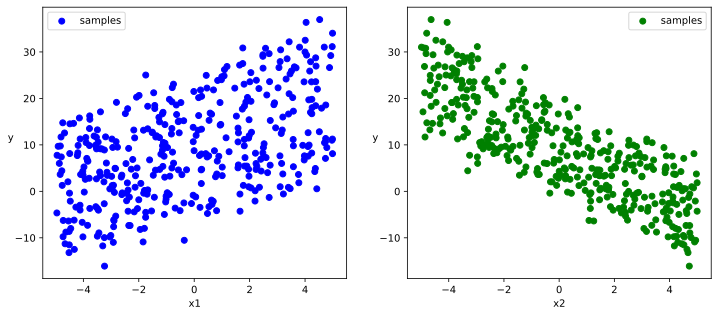

In [4]:
# 数据可视化
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))

# 绘制多个子图，1*2划分的第1个子图
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c = 'b', label = 'samples')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c = 'g', label = 'samples')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation = 0)

plt.show()

### 2. 构建数据管道

```python
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
```

In [5]:
ds = TensorDataset(X, Y)
train_size = int(n*0.7)
test_size = n - train_size
ds_train, ds_valid = torch.utils.data.random_split(ds, [train_size, test_size])
dl_train = DataLoader(ds_train, shuffle = True, batch_size = 10)
dl_valid = DataLoader(ds_valid, shuffle = True, batch_size = 10)

### 3. 定义模型

In [6]:
import torchkeras
from torchkeras import Model

class LR(Model):
    def __init__(self):
        super(LR, self).__init__()
        self.fc = nn.Linear(2, 1)
        
    def forward(self, x):
        return self.fc(x)

model = LR()

In [7]:
model.summary(input_shape = (2, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000027
----------------------------------------------------------------


In [8]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc.weight 	 torch.Size([1, 2])
fc.bias 	 torch.Size([1])


### 4. 训练模型

In [9]:
def mean_absolute_error(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true))

def mean_absolute_percent_error(y_pred, y_true):
    absolute_percent_error = (torch.abs(y_pred - y_true) + 1e-7) / (torch.abs(y_true) + 1e-7)
    return torch.mean(absolute_percent_error)

model.compile(loss_func=nn.MSELoss(),
              optimizer=torch.optim.Adam(model.parameters(), lr = 0.01),
              metrics_dict={"mae":mean_absolute_error, "mape":mean_absolute_percent_error})

dfhistory = model.fit(epochs=200, dl_train=dl_train, dl_val=dl_valid, log_step_freq=20)

# 1个step对应1个batch，batch_size = 10, 
# trainset 400*0.7=280 条数据，28个batch/step

Start Training ...

================================================================================2020-12-10 10:23:50
{'step': 20, 'loss': 172.934, 'mae': 10.324, 'mape': 0.977}

 +-------+---------+--------+-------+----------+---------+----------+
| epoch |   loss  |  mae   |  mape | val_loss | val_mae | val_mape |
+-------+---------+--------+-------+----------+---------+----------+
|   1   | 172.097 | 10.417 | 1.039 | 138.561  |  9.576  |  0.979   |
+-------+---------+--------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:50
{'step': 20, 'loss': 144.7, 'mae': 9.645, 'mape': 1.364}

 +-------+---------+-------+-------+----------+---------+----------+
| epoch |   loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+---------+-------+-------+----------+---------+----------+
|   2   | 150.603 | 9.821 | 1.285 | 121.474  |  9.004  |   0.96   |
+-------+---------+-------+-------+------

{'step': 20, 'loss': 29.812, 'mae': 5.004, 'mape': 3.64}

 +-------+--------+-------+-------+----------+---------+----------+
| epoch |  loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+--------+-------+-------+----------+---------+----------+
|   18  | 30.785 | 5.091 | 2.899 |  26.552  |   4.79  |  0.998   |
+-------+--------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:50
{'step': 20, 'loss': 29.355, 'mae': 4.972, 'mape': 3.547}

 +-------+--------+-------+-------+----------+---------+----------+
| epoch |  loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+--------+-------+-------+----------+---------+----------+
|   19  | 28.606 | 4.894 | 2.847 |  24.679  |  4.598  |  0.962   |
+-------+--------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:50
{'step': 


 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   35  | 9.491 | 2.544 | 1.686 |  7.851   |  2.382  |  0.502   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:51
{'step': 20, 'loss': 8.701, 'mae': 2.415, 'mape': 0.835}

 +-------+------+-------+-------+----------+---------+----------+
| epoch | loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+------+-------+-------+----------+---------+----------+
|   36  | 8.95 | 2.457 | 1.622 |   7.35   |   2.3   |  0.487   |
+-------+------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:51
{'step': 20, 'loss': 7.798, 'mae': 2.306, 'mape': 0.822}

 +-------+-------+------

{'step': 20, 'loss': 4.598, 'mae': 1.687, 'mape': 0.504}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   54  | 4.667 | 1.708 | 1.073 |  3.873   |  1.658  |  0.441   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:51
{'step': 20, 'loss': 4.625, 'mae': 1.712, 'mape': 1.125}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   55  | 4.599 | 1.695 | 1.066 |  3.848   |  1.648  |  0.441   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:51
{'step': 20, 'loss':


 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   73  | 4.241 | 1.619 | 0.963 |  3.675   |  1.546  |  0.445   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:52
{'step': 20, 'loss': 3.996, 'mae': 1.562, 'mape': 0.6}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   74  | 4.241 | 1.617 | 0.947 |  3.653   |  1.537  |  0.445   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:52
{'step': 20, 'loss': 4.154, 'mae': 1.581, 'mape': 1.093}

 +-------+-------+---


 +-------+-------+------+-------+----------+---------+----------+
| epoch |  loss | mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+------+-------+----------+---------+----------+
|   92  | 4.234 | 1.62 | 0.939 |  3.702   |   1.54  |  0.449   |
+-------+-------+------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:52
{'step': 20, 'loss': 4.157, 'mae': 1.609, 'mape': 1.156}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   93  | 4.227 | 1.617 | 0.936 |  3.658   |  1.526  |  0.447   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:52
{'step': 20, 'loss': 4.259, 'mae': 1.627, 'mape': 0.715}

 +-------+-------+------


 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  113  | 4.231 | 1.619 | 0.949 |   3.71   |  1.541  |   0.45   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:52
{'step': 20, 'loss': 4.135, 'mae': 1.596, 'mape': 0.554}

 +-------+------+-------+-------+----------+---------+----------+
| epoch | loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+------+-------+-------+----------+---------+----------+
|  114  | 4.23 | 1.619 | 0.945 |  3.699   |  1.538  |  0.449   |
+-------+------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:52
{'step': 20, 'loss': 4.063, 'mae': 1.572, 'mape': 0.958}

 +-------+-------+------


 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  134  | 4.232 | 1.618 | 0.921 |  3.733   |  1.547  |  0.449   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:53
{'step': 20, 'loss': 3.972, 'mae': 1.582, 'mape': 1.0}

 +-------+-------+------+-------+----------+---------+----------+
| epoch |  loss | mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+------+-------+----------+---------+----------+
|  135  | 4.234 | 1.62 | 0.943 |  3.691   |  1.535  |  0.449   |
+-------+-------+------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:53
{'step': 20, 'loss': 3.989, 'mae': 1.571, 'mape': 1.078}

 +-------+-------+-------+


 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  155  | 4.233 | 1.613 | 0.924 |  3.679   |  1.526  |  0.447   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:53
{'step': 20, 'loss': 4.08, 'mae': 1.625, 'mape': 1.078}

 +-------+-------+-------+------+----------+---------+----------+
| epoch |  loss |  mae  | mape | val_loss | val_mae | val_mape |
+-------+-------+-------+------+----------+---------+----------+
|  156  | 4.234 | 1.618 | 0.93 |  3.716   |  1.543  |  0.449   |
+-------+-------+-------+------+----------+---------+----------+

================================================================================2020-12-10 10:23:53
{'step': 20, 'loss': 4.141, 'mae': 1.581, 'mape': 1.006}

 +-------+-------+-------


 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  176  | 4.237 | 1.618 | 0.948 |  3.678   |   1.53  |  0.446   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:54
{'step': 20, 'loss': 3.969, 'mae': 1.572, 'mape': 1.099}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  177  | 4.228 | 1.616 | 0.945 |  3.734   |  1.549  |   0.45   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:54
{'step': 20, 'loss': 3.696, 'mae': 1.53, 'mape': 1.008}

 +-------+-------+--


 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  196  | 4.295 | 1.622 | 0.908 |  3.649   |  1.522  |  0.447   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:54
{'step': 20, 'loss': 3.839, 'mae': 1.543, 'mape': 1.045}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  197  | 4.229 | 1.614 | 0.939 |  3.757   |  1.554  |   0.45   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-12-10 10:23:54
{'step': 20, 'loss': 3.824, 'mae': 1.537, 'mape': 1.081}

 +-------+-------+-

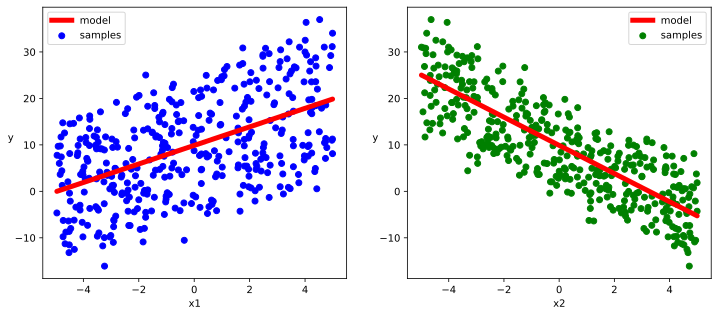

In [10]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))

w, b = model.state_dict()["fc.weight"], model.state_dict()["fc.bias"]

ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c = "b", label = "samples")
ax1.plot(X[:,0], w[0, 0]*X[:, 0]+b[0], "-r", linewidth = 5.0, label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c = "g", label = "samples")
ax2.plot(X[:, 1], w[0, 1]*X[:, 1]+b[0], "-r", linewidth = 5.0, label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation = 0)

plt.show()

### 4. 评估模型

In [11]:
dfhistory.tail()

,loss,mae,mape,val_loss,val_mae,val_mape
195,4.295082,1.621561,0.908274,3.649090,1.522203,0.447302
196,4.228507,1.614018,0.938803,3.756866,1.554147,0.449680
197,4.234721,1.621145,0.955003,3.688016,1.533643,0.448007
198,4.237068,1.616252,0.924888,3.684700,1.531252,0.448895
199,4.252279,1.616123,0.921021,3.664683,1.525581,0.446760


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


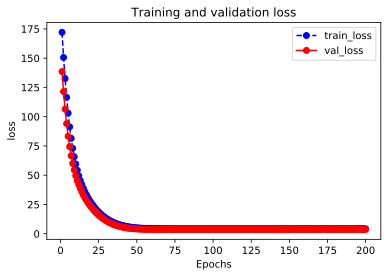

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(dfhistory, "loss")

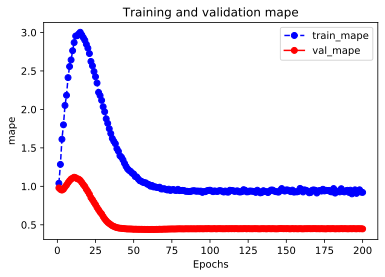

In [13]:
plot_metric(dfhistory, "mape")

In [14]:
model.evaluate(dl_valid)

{'val_loss': 3.664682845274607,
 'val_mae': 1.5255808780590694,
 'val_mape': 0.4467601714034875}

### 5. 使用模型

In [15]:
dl = DataLoader(TensorDataset(X))
model.predict(dl)[0:10]

tensor([[ 1.6808],
        [12.8371],
        [ 1.9809],
        [-2.3307],
        [ 4.9918],
        [ 9.8548],
        [10.4003],
        [ 5.2151],
        [ 4.7355],
        [ 9.7287]])

In [16]:
# 预测
model.predict(dl_valid)[0:10]

tensor([[12.1458],
        [ 1.7487],
        [29.6408],
        [ 7.0874],
        [-8.7076],
        [-2.3304],
        [28.1354],
        [ 8.3057],
        [-8.3834],
        [17.3338]])